In [1]:
from pathlib import Path

import pandas as pd

from caveat.evaluate.describe import frequency, transitions
from caveat.evaluate.describe.frequency import frequency_plots
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [2]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}


batch_paths = {
    # "Discrete RNN (Baseline)": Path("../logs/paper_d_rnn"),
    "Discrete CNN VAE": Path("../logs/paper_d_cnn_vae"),
    "Continuous RNN VAE": Path("../logs/paper_c_rnn_vae"),
    # "Continuous RNN JVAE": Path("../logs/paper_c_rnn_Jvae"),
}

# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}


def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_best(path: Path):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[0]
    dir = path / top
    yield latest(dir)


next(find_best(Path("../logs/paper_d_rnn")))

('DiscLSTM2', PosixPath('../logs/paper_d_rnn/DiscLSTM2/version_1'))

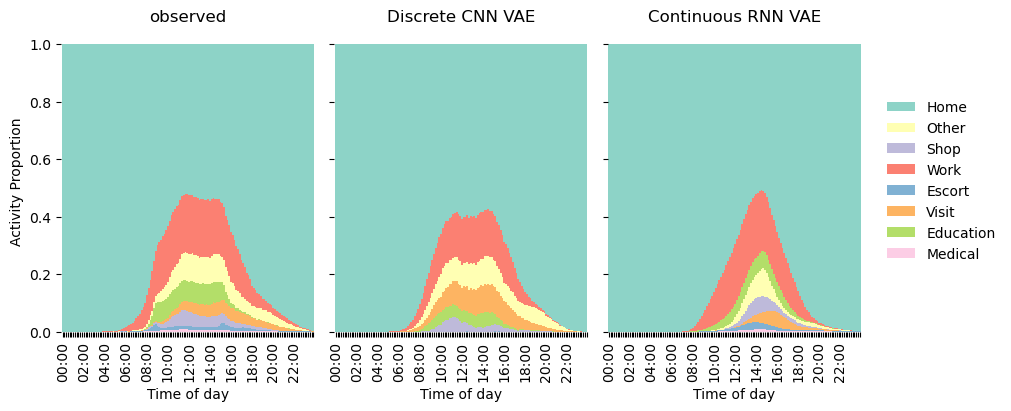

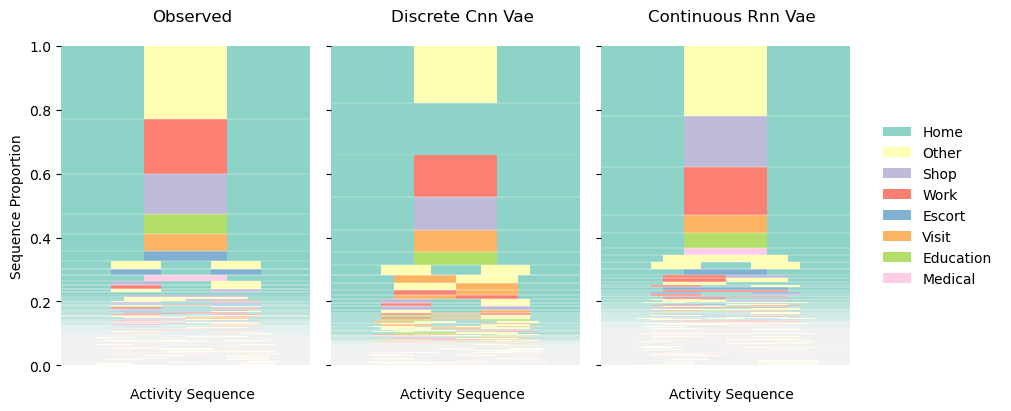

In [3]:
schedules = {
    n: pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
fig = frequency_plots(target_schedules, schedules, color=cmap, figsize=(10, 4))
fig = sequence_prob_plot(
    target_schedules, schedules, cmap=cmap, figsize=(10, 4)
)

In [4]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)

/tmp/ipykernel_257529/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_257529/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_257529/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

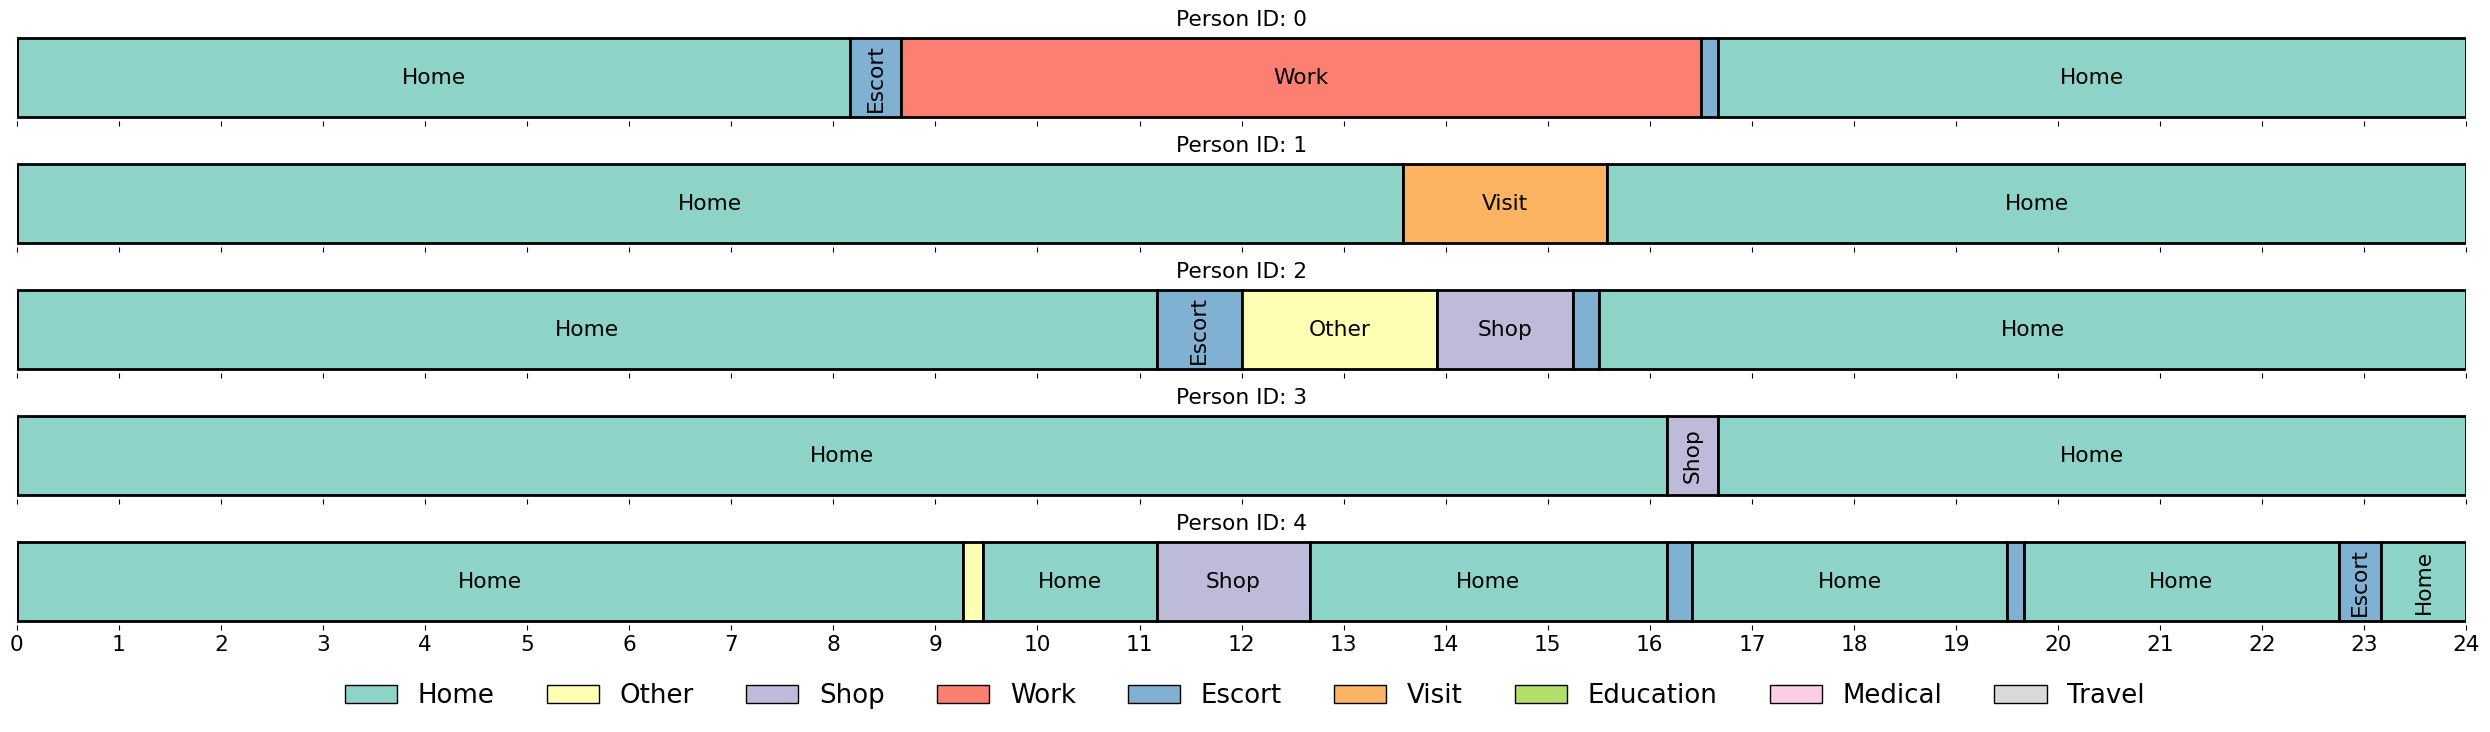

In [5]:
plot_schedules(target_schedules)

/tmp/ipykernel_257529/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_257529/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_257529/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

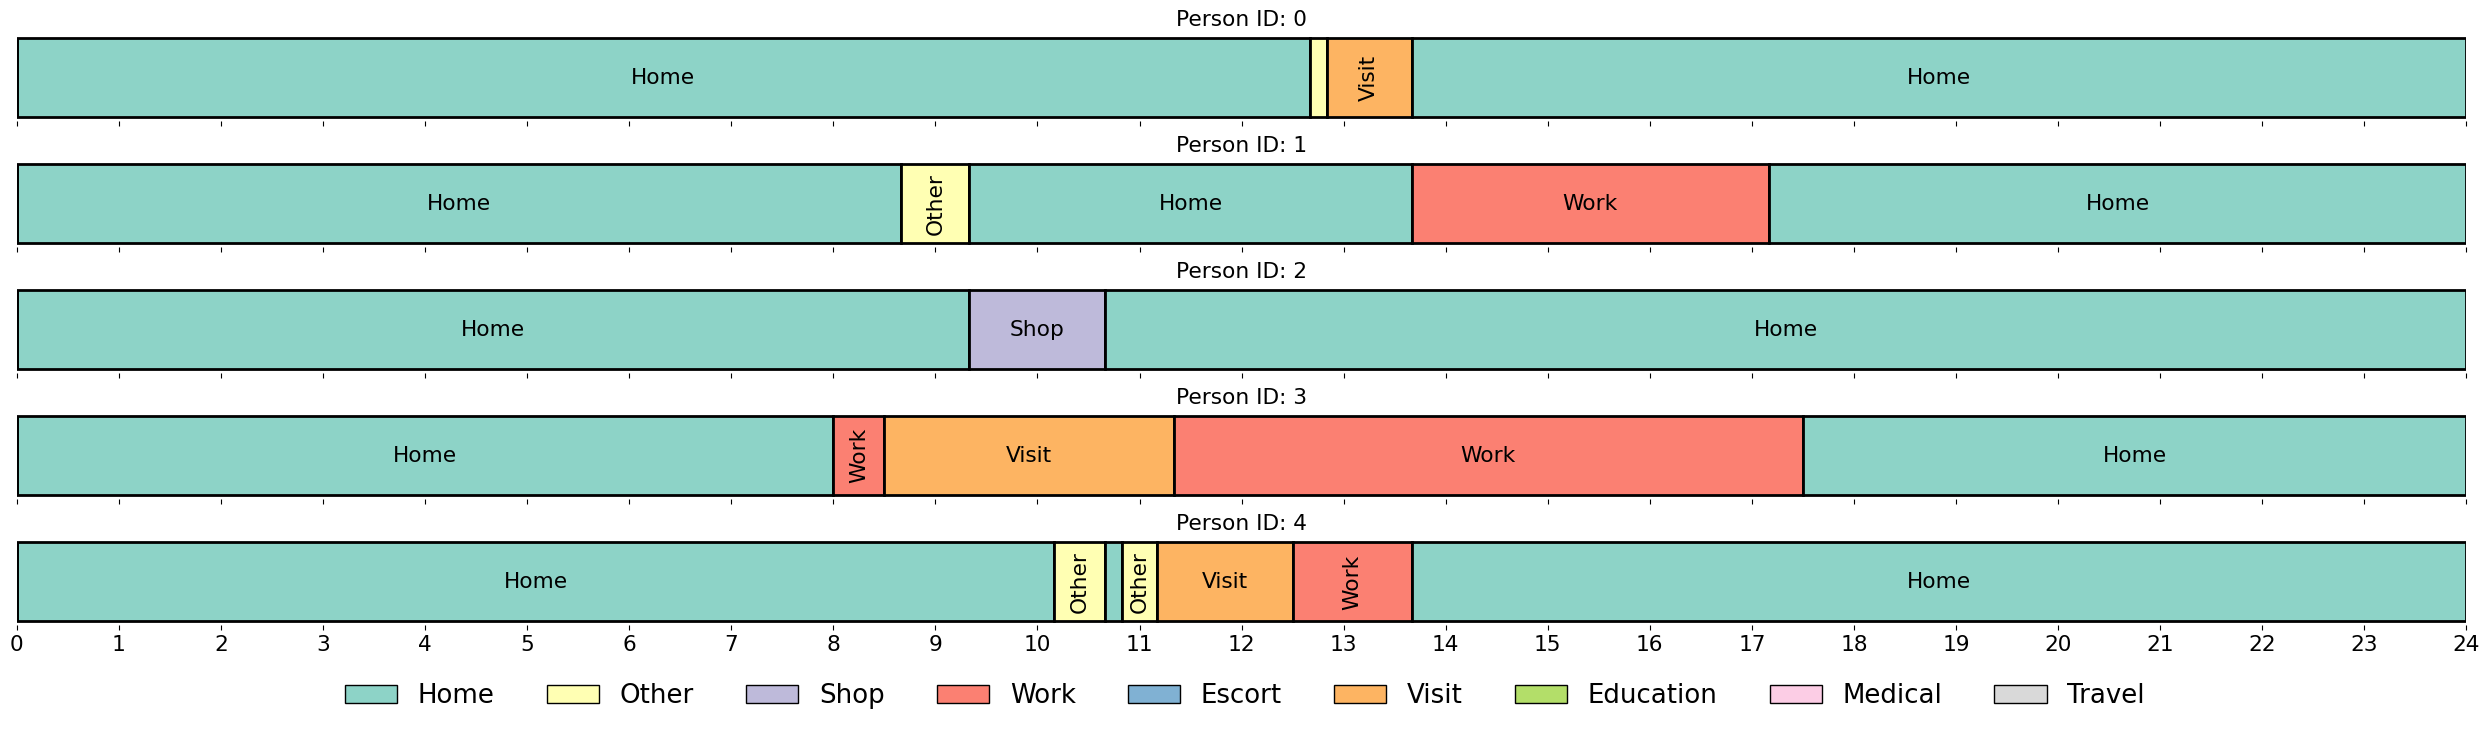

In [6]:
p = batch_paths["Discrete CNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

/tmp/ipykernel_257529/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_257529/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_257529/1738895634.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pand

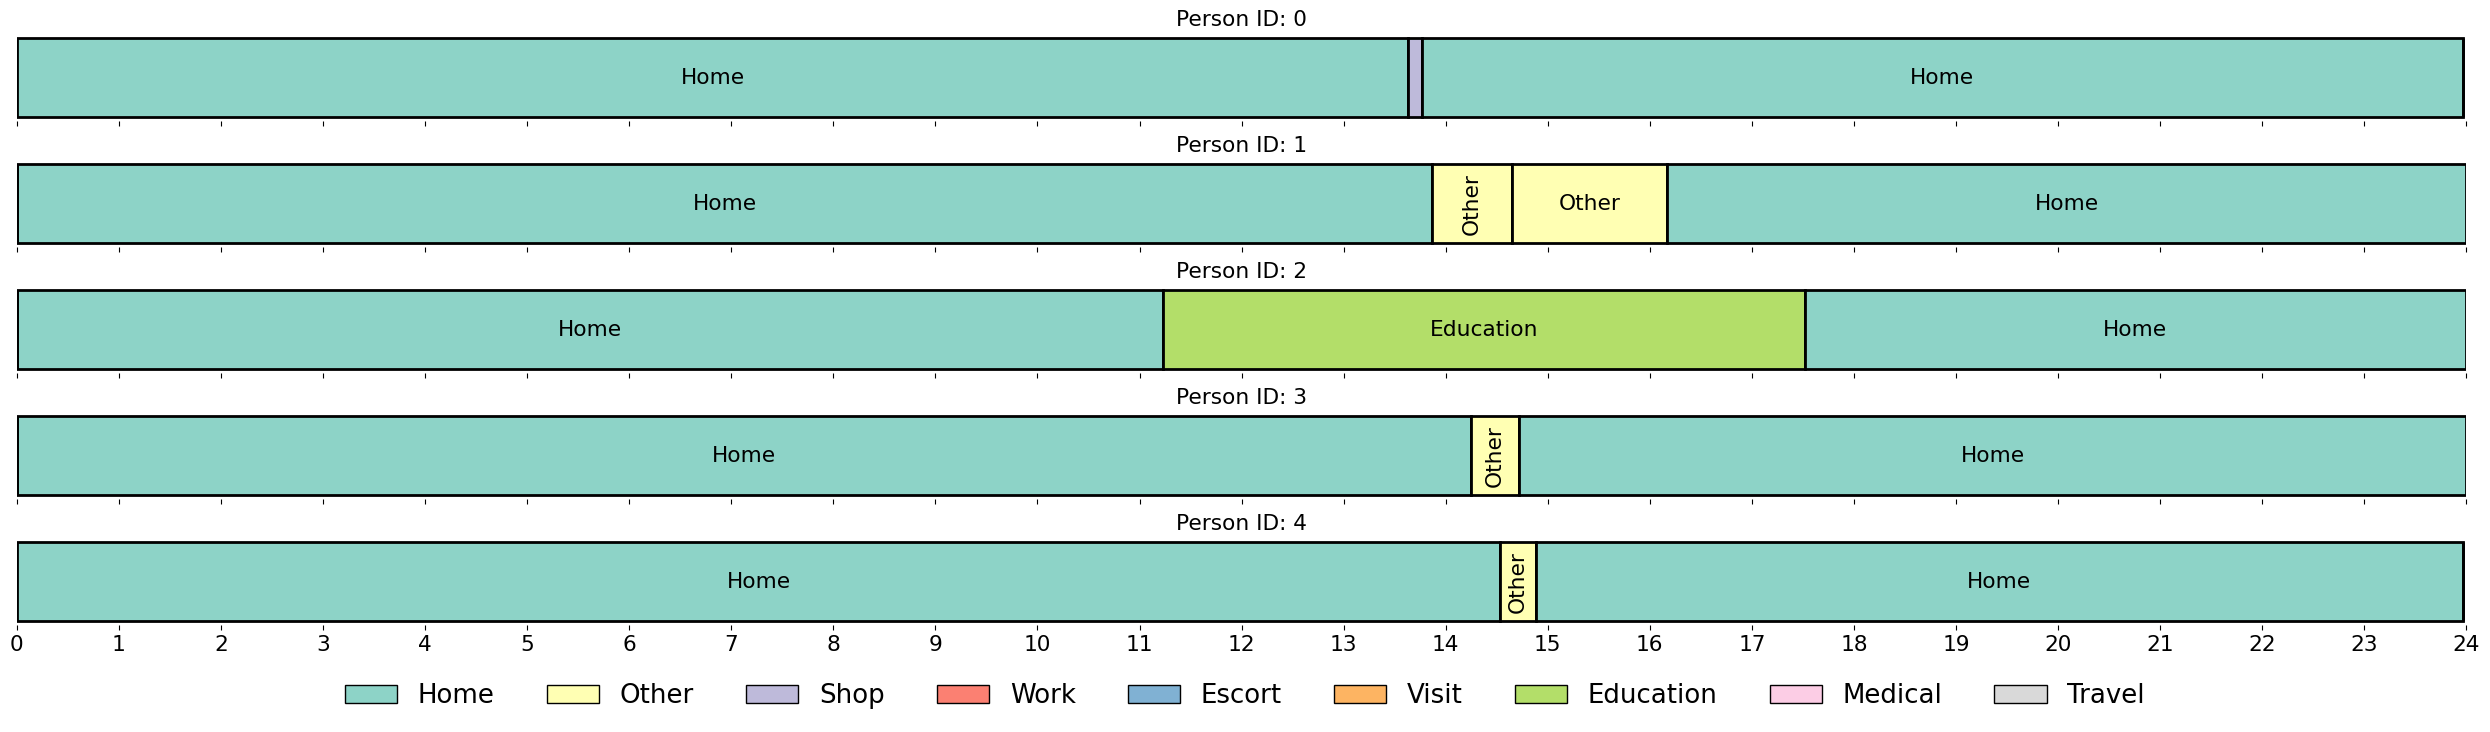

In [7]:
p = batch_paths["Continuous RNN VAE"]
schedules = pd.read_csv(next(find_best(p))[1] / "synthetic_schedules.csv")

plot_schedules(schedules)

In [8]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        distances_combined[(name, "mean")] = distances.mean(axis=1)
        distances_combined[(name, "std")] = distances.std(axis=1)
    distances_combined = distances_combined.T

    distances_combined = distances_combined.set_index(
        pd.MultiIndex.from_tuples(distances_combined.index)
    )
    distances_combined = distances_combined.unstack(level=-1)
    distances_combined = distances_combined.drop("creativity", axis=1)
    sample_quality = distances_combined["sample quality"]
    density = distances_combined[
        ["aggregate", "participations", "transitions", "timing"]
    ]

    # creativity

    return (sample_quality, density)


sample_quality, density = build_distance_tables(batch_paths)

In [9]:
print(sample_quality[::-1].to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrr}
\toprule
 & mean & std \\
\midrule
Discrete CNN VAE & 0.167 & 0.408 \\
Continuous RNN VAE & 0.211 & 0.387 \\
\bottomrule
\end{tabular}



In [10]:
print(density.loc[::-1].to_latex(float_format="{:.3f}".format))
density.loc[::-1]

\begin{tabular}{lrrrrrrrr}
\toprule
domain & \multicolumn{2}{r}{aggregate} & \multicolumn{2}{r}{participations} & \multicolumn{2}{r}{transitions} & \multicolumn{2}{r}{timing} \\
 & mean & std & mean & std & mean & std & mean & std \\
\midrule
Discrete CNN VAE & 0.129 & 0.275 & 0.473 & 0.438 & 0.023 & 0.010 & 0.175 & 0.177 \\
Continuous RNN VAE & 0.129 & 0.274 & 0.267 & 0.491 & 0.009 & 0.007 & 0.142 & 0.182 \\
\bottomrule
\end{tabular}



domain             aggregate           participations           transitions  \
                        mean       std           mean       std        mean   
Discrete CNN VAE    0.128965  0.274509       0.472923  0.438454    0.023270   
Continuous RNN VAE  0.129193  0.274193       0.267381  0.490571    0.009427   

domain                          timing            
                         std      mean       std  
Discrete CNN VAE    0.009955  0.174604  0.177126  
Continuous RNN VAE  0.006952  0.142042  0.182349

In [11]:
def build_description_tables(batch_paths, suffix=""):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(
            path / f"feature_descriptions{suffix}.csv"
        ).set_index(["domain", "feature"])
        columns = set(descriptions.columns)
        columns = list(columns - set(["observed", "description"]))
        # print(descriptions)

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        descriptions_combined[(name, "std")] = descriptions[columns].std(axis=1)

    # print(descriptions_combined)

    descriptions_combined = descriptions_combined.T
    descriptions_combined = descriptions_combined.set_index(
        pd.MultiIndex.from_tuples(descriptions_combined.index)
    )
    descriptions_combined = descriptions_combined.unstack(level=-1)

    observed = []
    descs = descriptions["observed"]
    for o in descs:
        observed.append(o)
        observed.append(0)

    descriptions_combined.loc["Observed"] = observed

    creativity = descriptions_combined["creativity"]
    sample_quality = descriptions_combined["sample quality"]
    density = descriptions_combined[
        ["aggregate", "participations", "transitions", "timing"]
    ]

    # creativity

    return (creativity, sample_quality, density)


creativity, sample_quality, density = build_description_tables(batch_paths)

In [12]:
print(creativity.loc[::-1, :].to_latex(float_format="{:.3f}".format))
creativity.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{diversity} & \multicolumn{2}{r}{novelty} \\
 & mean & std & mean & std \\
\midrule
Observed & 0.550 & 0.000 & 1.000 & 0.000 \\
Discrete CNN VAE & 0.372 & 0.157 & 0.880 & 0.024 \\
Continuous RNN VAE & 0.995 & 0.002 & 1.000 & 0.000 \\
\bottomrule
\end{tabular}



feature            diversity             novelty          
                        mean       std      mean       std
Observed            0.549724  0.000000  1.000000  0.000000
Discrete CNN VAE    0.371940  0.157331  0.880470  0.023689
Continuous RNN VAE  0.994660  0.002416  0.999946  0.000033

In [13]:
print(sample_quality.loc[::-1, :].to_latex(float_format="{:.3f}".format))
sample_quality.loc[::-1, :]

\begin{tabular}{lrrrr}
\toprule
feature & \multicolumn{2}{r}{duration} & \multicolumn{2}{r}{home based} \\
 & mean & std & mean & std \\
\midrule
Observed & 1.000 & 0.000 & 1.000 & 0.000 \\
Discrete CNN VAE & 1.000 & 0.000 & 1.000 & 0.000 \\
Continuous RNN VAE & 0.974 & 0.012 & 0.981 & 0.004 \\
\bottomrule
\end{tabular}



feature             duration          home based          
                        mean      std       mean       std
Observed            1.000000  0.00000   1.000000  0.000000
Discrete CNN VAE    1.000000  0.00000   1.000000  0.000000
Continuous RNN VAE  0.973597  0.01193   0.981121  0.004111

In [14]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_feature_description_tables(batch_paths)
table

Observed  Discrete CNN VAE  \
domain         feature                                               
creativity     diversity                0.549724          0.371940   
               novelty                  1.000000          0.880470   
sample quality duration                 1.000000          1.000000   
               home based               1.000000          1.000000   
aggregate      agg. frequency           0.688881          0.766869   
participations lengths                  3.680427          2.956731   
               pair participation rate  0.038617          0.072635   
               participation rate       0.085591          0.078271   
transitions    2-gram                   0.041891          0.217555   
               3-gram                   0.005097          0.063912   
timing         durations                0.271708          0.354564   
               end times                0.683808          0.722986   
               start times              0.412100          0.368422   
               start-durations          0.689380          0.727948   

                                        Continuous RNN VAE    Description  
domain         feature                                                     
creativity     diversity                          0.994660   prob. unique  
               novelty                            0.999946    prob. novel  
sample quality duration                           0.973597       duration  
               home based                         0.981121          prob.  
aggregate      agg. frequency                     0.760902  average freq.  
participations lengths                            3.524109        length.  
               pair participation rate            0.038162       av rate.  
               participation rate                 0.080965       av. rate  
transitions    2-gram                             0.042009       av. rate  
               3-gram                             0.004936       av. rate  
timing         durations                          0.276320        average  
               end times                          0.706178        average  
               start times                        0.429858        average  
               start-durations                    0.708213        average

In [15]:
print(table.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llrrrl}
\toprule
 &  & Observed & Discrete CNN VAE & Continuous RNN VAE & Description \\
domain & feature &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{creativity} & diversity & 0.550 & 0.372 & 0.995 & prob. unique \\
 & novelty & 1.000 & 0.880 & 1.000 & prob. novel \\
\cline{1-6}
\multirow[t]{2}{*}{sample quality} & duration & 1.000 & 1.000 & 0.974 & duration \\
 & home based & 1.000 & 1.000 & 0.981 & prob. \\
\cline{1-6}
aggregate & agg. frequency & 0.689 & 0.767 & 0.761 & average freq. \\
\cline{1-6}
\multirow[t]{3}{*}{participations} & lengths & 3.680 & 2.957 & 3.524 & length. \\
 & pair participation rate & 0.039 & 0.073 & 0.038 & av rate. \\
 & participation rate & 0.086 & 0.078 & 0.081 & av. rate \\
\cline{1-6}
\multirow[t]{2}{*}{transitions} & 2-gram & 0.042 & 0.218 & 0.042 & av. rate \\
 & 3-gram & 0.005 & 0.064 & 0.005 & av. rate \\
\cline{1-6}
\multirow[t]{4}{*}{timing} & durations & 0.272 & 0.355 & 0.276 & average \\
 & end times & 0.684 & 0.723 & 0.706 & avera

In [16]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature"])
        .head(10)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_all_description_tables(batch_paths)
table

Observed  Discrete CNN VAE  \
domain         feature    segment                                      
creativity     novelty    all             1.000000      20349.127487   
               diversity  all             0.549724      20348.896336   
sample quality home based last act home   1.000000      20349.181818   
               duration   total duration  1.000000      20349.181818   
               home based first act home  1.000000      20349.181818   
...                                            ...               ...   
timing         durations  home3           0.215337        664.912781   
                          home6           0.195602         68.422484   
                          education2      0.176111         54.103062   
                          home4           0.166431        239.356606   
                          home5           0.157416        121.167674   

                                          Continuous RNN VAE   Description  
domain         feature    segment                                           
creativity     novelty    all                   20349.181794   prob. novel  
               diversity  all                   20349.179391  prob. unique  
sample quality home based last act home         20349.164655         prob.  
               duration   total duration        20349.169817      duration  
               home based first act home        20349.181818         prob.  
...                                                      ...           ...  
timing         durations  home3                   230.755769       average  
                          home6                     0.818182       average  
                          education2                6.576676       average  
                          home4                    25.029964       average  
                          home5                     5.109870       average  

[92 rows x 4 columns]

In [17]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))


creativity

novelty

\begin{tabular}{lrrrl}
\toprule
 & Observed & Discrete CNN VAE & Continuous RNN VAE & Description \\
segment &  &  &  &  \\
\midrule
all & 1.000 & 20349.127 & 20349.182 & prob. novel \\
\bottomrule
\end{tabular}

diversity

\begin{tabular}{lrrrl}
\toprule
 & Observed & Discrete CNN VAE & Continuous RNN VAE & Description \\
segment &  &  &  &  \\
\midrule
all & 0.550 & 20348.896 & 20349.179 & prob. unique \\
\bottomrule
\end{tabular}


sample quality

home based

\begin{tabular}{lrrrl}
\toprule
 & Observed & Discrete CNN VAE & Continuous RNN VAE & Description \\
segment &  &  &  &  \\
\midrule
last act home & 1.000 & 20349.182 & 20349.165 & prob. \\
first act home & 1.000 & 20349.182 & 20349.182 & prob. \\
\bottomrule
\end{tabular}

duration

\begin{tabular}{lrrrl}
\toprule
 & Observed & Discrete CNN VAE & Continuous RNN VAE & Description \\
segment &  &  &  &  \\
\midrule
total duration & 1.000 & 20349.182 & 20349.170 & duration \\
\bottomrule
\end{tabular}


aggr

In [18]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_subs_description_tables(batch_paths)
table

Observed  Discrete CNN VAE  \
domain     feature   segment sub_pop                                       
creativity novelty   all     gender=F              1.0       9806.039291   
                             income=3              1.0       4176.511101   
                             car_access=yes        1.0      17417.127961   
                             age_group=5-11        1.0       1127.898572   
                             age_group=50-70       1.0       5864.954700   
...                                                ...               ...   
timing     durations visit12 income=4              NaN          0.091540   
                     visit6  income=4              NaN          4.184014   
                     visit7  income=4              NaN          1.637696   
                     visit8  income=4              NaN          0.727904   
                     visit9  income=4              NaN          0.273359   

                                              Continuous RNN VAE  Description  
domain     feature   segment sub_pop                                           
creativity novelty   all     gender=F                9806.090894  prob. novel  
                             income=3                4176.545418  prob. novel  
                             car_access=yes         17417.181798  prob. novel  
                             age_group=5-11          1127.909091  prob. novel  
                             age_group=50-70         5864.999983  prob. novel  
...                                                          ...          ...  
timing     durations visit12 income=4                        NaN          NaN  
                     visit6  income=4                        NaN          NaN  
                     visit7  income=4                        NaN          NaN  
                     visit8  income=4                        NaN          NaN  
                     visit9  income=4                        NaN          NaN  

[10519 rows x 4 columns]

In [19]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment sub_pop                          
participations participation rate work0   work_status=student   0.052345   
                                          work_status=employed  0.443468   

                                                                Discrete CNN VAE  \
domain         feature            segment sub_pop                                  
participations participation rate work0   work_status=student         467.110405   
                                          work_status=employed      10215.381675   

                                                                Continuous RNN VAE  \
domain         feature            segment sub_pop                                    
participations participation rate work0   work_status=student           467.116114   
                                          work_status=employed        10215.383764   

                                                               Description  
domain         feature            segment sub_pop                           
participations participation rate work0   work_status=student     av. rate  
                                          work_status=employed    av. rate

In [20]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]

Observed  \
domain         feature            segment    sub_pop                          
participations participation rate education0 work_status=student   0.384951   
                                             work_status=employed  0.004419   

                                                                   Discrete CNN VAE  \
domain         feature            segment    sub_pop                                  
participations participation rate education0 work_status=student         313.571629   
                                             work_status=employed       6845.116922   

                                                                   Continuous RNN VAE  \
domain         feature            segment    sub_pop                                    
participations participation rate education0 work_status=student           467.028221   
                                             work_status=employed        10215.304577   

                                                                  Description  
domain         feature            segment    sub_pop                           
participations participation rate education0 work_status=student     av. rate  
                                             work_status=employed    av. rate

In [21]:
for i in range(5):
    schedules = {
        k: pd.read_csv(list(iter_models(v))[i] / "synthetic_schedules.csv")
        for k, v in batch_paths.items()
    }
    fig = frequency.frequency_plots(target_schedules, schedules)
    fig = transitions.sequence_prob_plot(target_schedules, schedules)

TypeError: unsupported operand type(s) for /: 'tuple' and 'str'

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[0] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[1] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[2] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[3] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
# freq plots
# fig, axs = plt.subplots(5, 1, figsize=(5, 12))
# frequency.plot_agg_acts("NTS", target_schedules, class_map, ax=axs[0])
schedules = {
    k: pd.read_csv(list(iter_models(v))[4] / "synthetic_schedules.csv")
    for k, v in batch_paths.items()
}
fig = frequency.frequency_plots(target_schedules, schedules)

In [ ]:
distances_subs.set_index(["domain", "feature", "sub_pop"]).loc["timing"]

In [ ]:
from caveat.evaluate.distance.wasserstein import emd
from caveat.evaluate.features.frequency import activity_frequencies

In [ ]:
sample = pd.read_csv("../logs/best_jm_z24/version_30/synthetic_schedules.csv")
target = pd.read_csv("../tmp/nts_home_schedules.csv")
sample.head()

In [ ]:
freqs = activity_frequencies(sample)
support, density = freqs["work"]
tsupport, tdensity = activity_frequencies(target)["work"]
emd((support, density), (tsupport, tdensity))

In [ ]:
from caveat.evaluate.describe.features import average_density

In [ ]:
average_density(freqs)

In [ ]:
tdensity

In [ ]:
import numpy as np

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
attributes.head()

In [ ]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_to_idx = {v: k for k, v in age_mapping.items()}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}

attributes["age_group"] = attributes.age.map(age_to_idx).map(age_group_mapping)
attributes.head()
attributes.to_csv("../tmp/nts_home_attributes_groups.csv", index="pid")